In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import MDAnalysis as mda
from MDAnalysis.analysis import rms

In [ ]:
from biobb_analysis.ambertools.cpptraj_slice import cpptraj_slice
prop = {
    'start': 1,
    'end': -1,
    'steps': 1000,
    'mask': 'all-atoms',
    'format': 'nc'
}
cpptraj_slice(input_top_path='../example/1aki/structure.ions.parmtop',
            input_traj_path='../example/1aki/pmemd.gamd.nc',
            output_cpptraj_path='../example/1aki/pmemd.gamd.sliced.nc',
            properties=prop)

## Computing RMSD of the protein:

RMSD of the protein with respect to the initial frame can be calculated by loading the parameter file. (.prmtop) and trajectory file (.nc). In the simulation, the parameter file might be named .parmtop. But essentially, both .parmtop and .prmtop are the same. Therefore a simple renaming of the file ould suffice.

If one decides to compute the RMSD of the protein, other than backbone, that can be done by selecting a different atomgroup. More details can be found at MDAnalysis tutorials (https://userguide.mdanalysis.org/stable/). 

In [ ]:
# Load the topology file and the trajectory file
topology = '../example/1aki/structure.ions.prmtop'
trajectory = '../example/1aki/pmemd.gamd.nc'
u = mda.Universe(topology, trajectory)

# Select the protein atoms
protein = u.select_atoms('protein')

# Calculate the RMSD for the protein
R = rms.RMSD(protein, protein, select='backbone')
R.run()

In [ ]:
# Convert the RMSD results to a pandas DataFrame
rmsd_df = pd.DataFrame(R.rmsd, columns=['Frame', 'Time', 'RMSD'])

# Plot the RMSD values using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=rmsd_df, x='Frame', y='RMSD')
plt.title('RMSD of Protein Over Time')
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.show()

## Computing RMSF of the protein residues:

The root mean square fluctuation (RMSF) of the protein residues with respect to a mean protein conformation is computed below. Here, the fluctuation of CA atoms of the protein are chosen for computing the RMSF. The protein needs to be realigned prior to computing the RMSF as the global translation and rotation of the protein need to be removed before the calculation of RMSF.

In [ ]:
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSF
import MDAnalysis.transformations as trans

topology = '../example/1aki/structure.ions.prmtop'
trajectory = '../example/1aki/pmemd.free.nc'
u = mda.Universe(topology, trajectory)

# Select the protein atoms
protein = u.select_atoms('protein')
not_protein = u.select_atoms('not protein')

transforms = [trans.unwrap(protein), trans.center_in_box(protein, wrap=True), trans.wrap(not_protein)]

u.trajectory.add_transformations(*transforms)

prealigner = align.AlignTraj(u, u, select="protein and name CA", in_memory=True).run()

ref_coordinates = u.trajectory.timeseries(asel=protein).mean(axis=1)

reference = mda.Merge(protein).load_new(ref_coordinates[:, None, :], order="afc")

aligner = align.AlignTraj(u, reference, select="protein and name CA", in_memory=True).run()

calphas = protein.select_atoms("name CA")
rmsfer = RMSF(calphas, verbose=True).run()

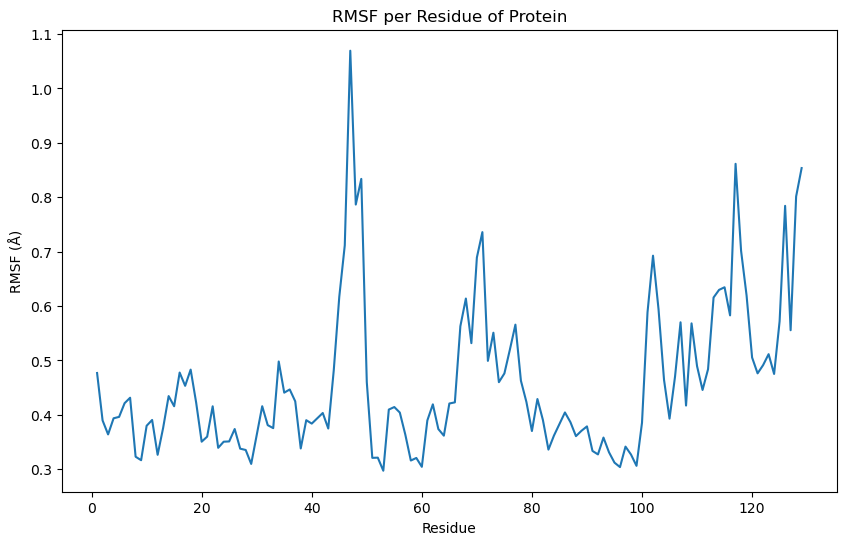

In [17]:
# Create a DataFrame with the RMSF results
residue_ids = [residue.resid for residue in protein.residues]

rmsf_df = pd.DataFrame({'Residue': residue_ids, 'RMSF': rmsfer.rmsf})

# Plot the RMSF values using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=rmsf_df, x='Residue', y='RMSF')
plt.title('RMSF per Residue of Protein')
plt.xlabel('Residue')
plt.ylabel('RMSF (Å)')
plt.show()

## Principal component analysis (PCA):

We have computed the principal components of motion of the protein from the trajectory data here. This approach looks at the greatest change or the variance in the protein motion. However, other methods such as tICA or dPCA can be used to extract more information regarding the motion of the protein. 

In [14]:
from MDAnalysis.analysis import pca

topology = '../example/1aki/structure.ions.prmtop'
trajectory = '../example/1aki/pmemd.free.nc'
u = mda.Universe(topology, trajectory)

# Select the protein atoms
protein = u.select_atoms('backbone')

# Perform PCA on the Universe
pca_analysis = pca.PCA(u, select='backbone').run()

# Project the AtomGroup onto the first two principal components
pc1 = pca_analysis.transform(protein, n_components=1)
pc2 = pca_analysis.transform(protein, n_components=2)

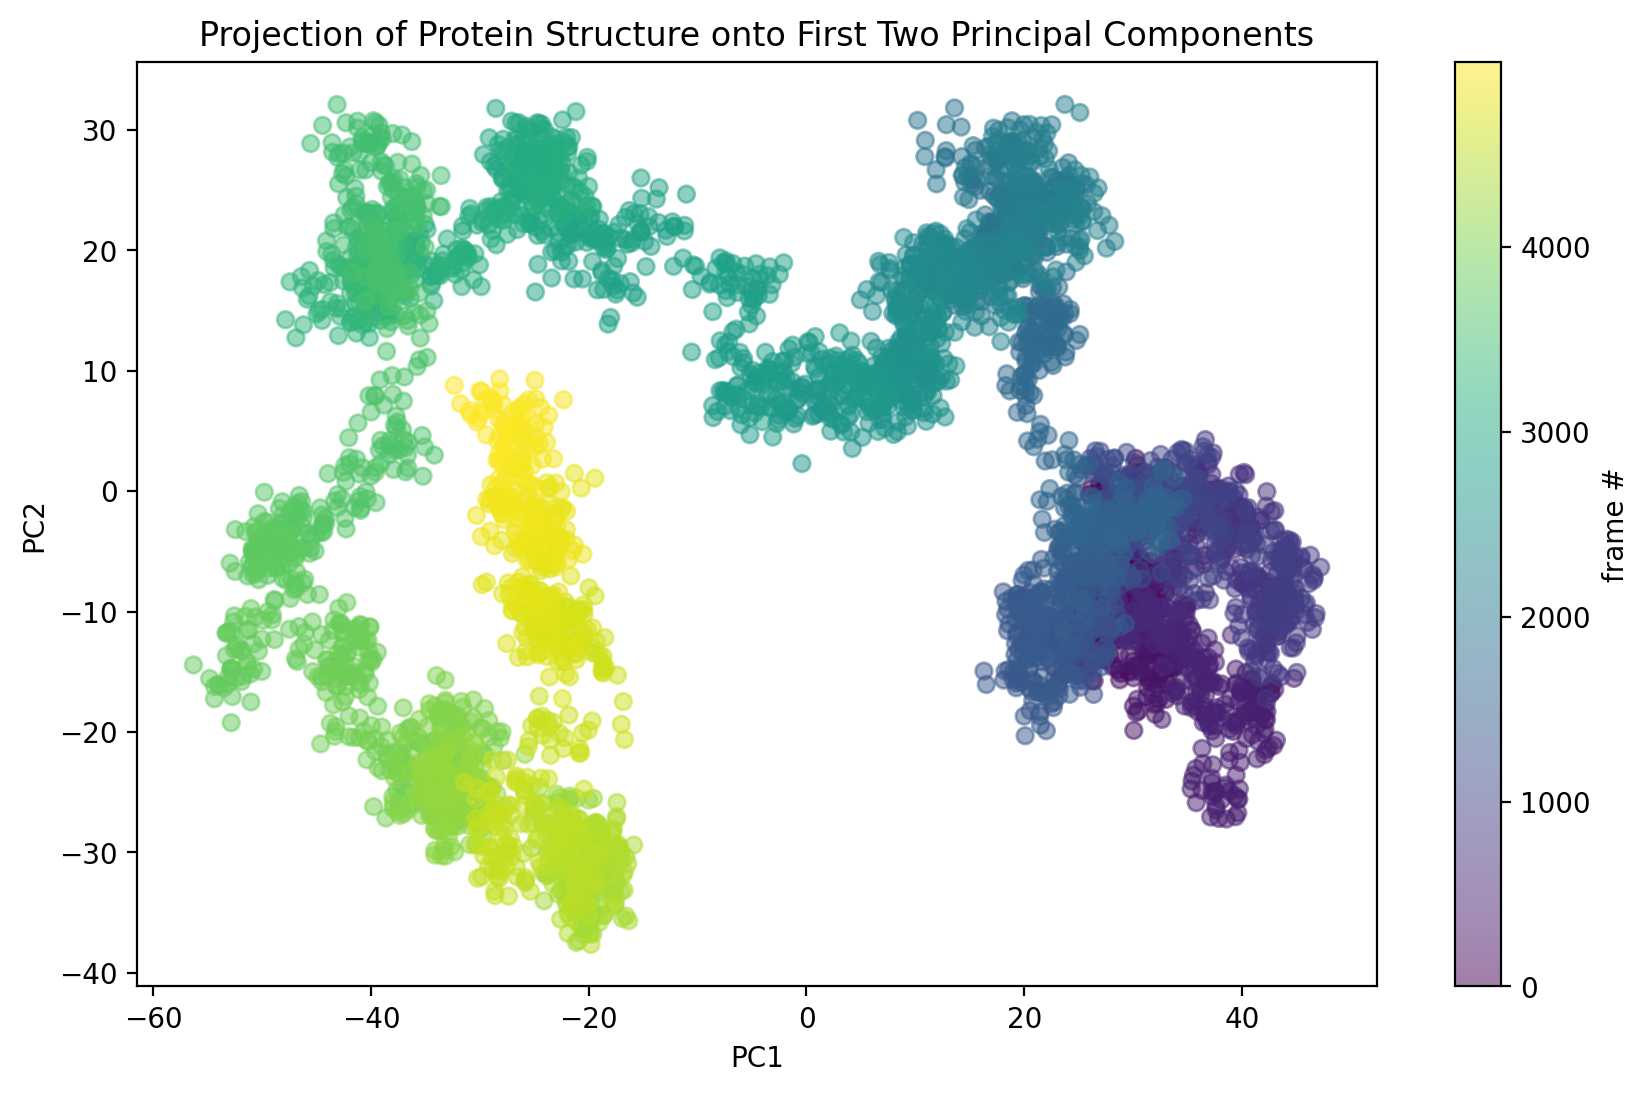

In [22]:
# Plot the projection onto the first two principal components
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution

plt.figure(figsize=(10, 6))
plt.scatter(pc1, pc2[:, 1], marker='o', c = range(len(pc1)), alpha=0.5)
plt.title('Projection of Protein Structure onto First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

cbar = plt.colorbar()
cbar.set_label('frame #')

plt.show()